<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-Setup" data-toc-modified-id="Notebook-Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook Setup</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Motivation-example" data-toc-modified-id="Motivation-example-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Motivation example</a></span></li><li><span><a href="#K-means-adapted-algorithm" data-toc-modified-id="K-means-adapted-algorithm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>K-means adapted algorithm</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Applying-it-to-the-previously-described-case-study" data-toc-modified-id="Applying-it-to-the-previously-described-case-study-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Applying it to the previously described case study</a></span></li></ul></li></ul></div>

# Notebook Setup

In [17]:
#Basic libraries
import numpy as np
import warnings #easier to ignore warnings
warnings.filterwarnings('ignore')
import requests
from pandas.io.json import json_normalize 
import pandas as pd
pd.set_option('display.max_columns', None) #for better exploratory analysis

#Spatial analysis
from shapely.geometry import Point, Polygon, MultiPoint

#Progress bar
from tqdm.notebook import tqdm

#Machine learning
from sklearn.cluster import KMeans

#Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import folium #map rendering library

print('Libraries imported.')

Libraries imported.


# Introduction

This repository explains how a quick method for evenly placing a certain number of points within an irregular polygon has been developed.

# Motivation example

There may be many reasons to generate a uniformly distributed mesh of points within a certain 2D object. In this case, the main motivation comes from a case study with geospatial data and venue information API's. 

When it comes to fetching information from commercial venues and spatial features of a city, Foursquare's Places API is a very common tool to access this kind of data. However, when trying to scrape Foursquare's API in order to get all possible venues within a certain distance of a specific location, the API has its limits. 

**EXAMPLE**

---

Importing an polygon example from `polygon_example.csv`. This particular polygon corresponds to the boundary of a neighborhood in Barcelona. Its values represent longitude and latitude coordinates.

In [2]:
polygon_coordinates = np.genfromtxt('polygon_example.csv', delimiter=',')
polygon_coordinates[:5]

array([[ 2.1709089 , 41.40181727],
       [ 2.17220607, 41.40082898],
       [ 2.17297209, 41.40024664],
       [ 2.17332455, 41.39998087],
       [ 2.17408126, 41.39941028]])

Once imported, we can visualize it in multiple ways. In this case, I create a `shapely` Polygon object:

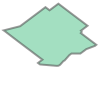

In [3]:
polygon = Polygon(polygon_coordinates)
polygon

Using shapely eases some tasks, like finding the centroid of the polygon for example:

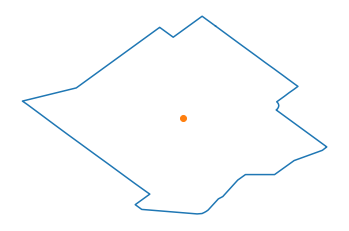

In [4]:
centroid = polygon.centroid
x_pol,y_pol = polygon.exterior.xy
x_cen,y_cen = centroid.coords[0]

fig, ax = plt.subplots()
ax.plot(x_pol,y_pol)
ax.plot(x_cen,y_cen, marker='o')
plt.axis('off')
plt.show()

Defining Foursquare's API credentials and taking a query request at the centroid:

In [5]:
CLIENT_ID = 'FZWQT5RYYRNBRD3KYK50VXNZ2APAF5MTKDCNEAEK1T0EWAQG' # your Foursquare ID
CLIENT_SECRET = 'UQFRDRPQM1JNCB3TSLXKZNMECFJWSBYOCU2N2KGPQFMVMKIY' # your Foursquare Secret
VERSION = '20180601'
radius = 750
lng,lat = centroid.coords[0]
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&intent=explore&ll={},{}&radius=750&limit=1000'.format(CLIENT_ID,
                                                                         CLIENT_SECRET,
                                                                         VERSION,
                                                                         lat,
                                                                         lng
                                                                         )
#Request query
results = requests.get(url).json()
print('{} venues found'.format(len(results['response']['venues'])))
lng_list = [venue['location']['lng'] for venue in results['response']['venues']]
lat_list = [venue['location']['lat'] for venue in results['response']['venues']]

126 venues found


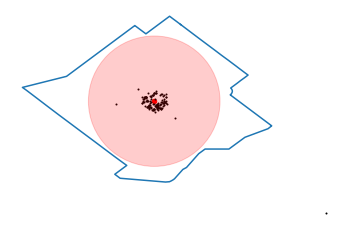

In [6]:
fig, ax = plt.subplots()
ax.plot(x_pol,y_pol)
ax.scatter(x_cen,y_cen, marker='o', s = 20, color='r')
#Plotting the venues
for lng,lat in zip(lng_list,lat_list):
    ax.scatter(lng,lat, marker='.', s = 4, color = 'k')
#Plotting the query radius
radius_lat_units = 750/111320 #meters to lat transformation
circle1 = plt.Circle((x_cen, y_cen), radius_lat_units, color='r', alpha=0.2)
ax.add_artist(circle1)
plt.axis('off')
plt.show()

We can see how Foursquare's API fails to retrieve venues uniformly within the given radius, and it only provides 126 results. These results are concentrated around the query location. 

Moreover, even if it in its [online docs]() explicitly says that:
"*(within the `intent` = 'browse' parameter) A region to search can be defined by including either the `ll` and `radius` parameters, or the `sw` and `ne`*"
The radius parameter is somehow ignore by the API:

In [7]:
radius = 15
lng,lat = centroid.coords[0]
url = 'https://api.foursquare.com/v2/\
venues/search?&client_id={}&client_secret={}&\
v={}&intent=explore&ll={},{}&radius={}&limit=1000'.format(CLIENT_ID,
                                                          CLIENT_SECRET,
                                                          VERSION,
                                                          lat,
                                                          lng,
                                                          radius
                                                         )
#Request query
results = requests.get(url).json()
print('{} venues found'.format(len(results['response']['venues'])))

126 venues found


# K-means adapted algorithm



This class generates a grid of points (defaults to 100x100, but can be modified according to the desired scale) on top of any irregular polygon.

It then determines which points are within the polygon or outside of it.

Finally it performs a k-means clustering of the inner points. The k-means algorithm itself has inside its optimization objective function, the goal of finding the maximum distance between clusters' centroids. Therefore, it will automatically distribute a certain number of points (the clusters' centroids) evenly within the polygon.

In practice, the k-means algorithm is very fast (one of the fastest clustering algorithms available), but it falls in local minima. That's why it can be useful to restart it several times (n_init) parameter.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from shapely.geometry import Point, Polygon, MultiPoint

class PointsDistributor():
    """
    Evenly spacing of a certain number of points within an irregular polygon.
    In order to do so it first generates a grid of points 
    (defaults to 100x100, but can be modified according to the desired scale) 
    on top of any irregular polygon.
    
    Then it determines which points are within the polygon or outside of it.
    
    Finally it performs a k-means clustering of the inner points. 
    The k-means algorithm itself has inside its optimization objective function, 
    the goal of finding the maximum distance between clusters' centroids. 
    Therefore, it will automatically distribute a certain number of points 
    (the clusters' centroids) evenly within the polygon.
    
    """
    def __init__(self, coords, grid_size =(100,100)):
        """
        Input arguments:
            coords: polygon boundary coordinates (long,lat)
            grid_size: number of points in each side of the initial grid
        """
        self.coords = coords
        self.polygon = Polygon(self.coords) 
        self._generate_grid(grid_size)
    
    ### Auxiliary functions ###
    def _generate_grid(self, grid_size):
        self.dim_range = np.ptp(self.coords, axis = 0)
        delta = self.dim_range*[1/item for item in (100,100)]
        SW = (self.polygon.bounds[0], self.polygon.bounds[1])

        self.inner_pts = []
        self.outer_pts = []

        for i in range(100):
            for j in range(100):
                p = Point(SW + (i,j)*delta)
                if self.polygon.contains(p):
                    self.inner_pts.append(p)
                else:
                    self.outer_pts.append(p)
        self.X = np.array([pt.coords[0] for pt in self.inner_pts])
    
    def _create_inner_clusters(self):
        self.inner_clusters = []
        for label in range(self.n):
            my_members = (self.labels == label)
            pts = self.X[my_members, :]
            self.inner_clusters.append(MultiPoint(pts).convex_hull)
            
    ### Callable functions ###
    def view_polygon(self):
        centroid = self.polygon.centroid
        x_cen,y_cen = centroid.coords[0]
        x_pol,y_pol = self.polygon.exterior.xy

        fig, ax = plt.subplots()
        ax.plot(x_pol,y_pol)
        ax.plot(x_cen,y_cen, marker='o')
        plt.axis('off')
        plt.show()
        
    def view_grid(self):
        centroid = self.polygon.centroid
        x_cen,y_cen = centroid.coords[0]
        x_pol,y_pol = self.polygon.exterior.xy
        x_inner_pts = [pt.coords[0][0] for pt in self.inner_pts]
        y_inner_pts = [pt.coords[0][1] for pt in self.inner_pts]
        x_outer_pts = [pt.coords[0][0] for pt in self.outer_pts]
        y_outer_pts = [pt.coords[0][1] for pt in self.outer_pts]

        fig, ax = plt.subplots()
        ax.plot(x_pol,y_pol)
        ax.scatter(x_cen,y_cen, marker='o', s= 30, color= 'k')
        ax.scatter(x_inner_pts,y_inner_pts, marker='o', s= 0.5, color= 'b')
        ax.scatter(x_outer_pts,y_outer_pts, marker='o', s= 0.5, color= 'r')
        plt.axis('off')
        plt.show()
    
    def place_points(self, n):
        self.n = n
        k_means = KMeans(init="k-means++", n_clusters=n, n_init=10)
        k_means.fit(self.X)
        self.labels = k_means.labels_
        self.cluster_centers = k_means.cluster_centers_
        self._create_inner_clusters()
    
    def view_point_placement(self):
        fig,ax = plt.subplots()
        colors = plt.cm.Spectral(np.linspace(0, 1, len(set(self.labels))))
        for k, col in zip(range(len(self.cluster_centers)), colors):
            # create a list of all datapoints, where the datapoitns that are 
            # in the cluster (ex. cluster 0) are labeled as true, else they are
            # labeled as false.
            my_members = (self.labels == k)
            # define the centroid, or cluster center.
            cluster_center = self.cluster_centers[k]
            # plot the datapoints with color col.
            ax.plot(self.X[my_members, 0], self.X[my_members, 1], 'w', markerfacecolor=col, marker='.')
            # plot the centroids with specified color, but with a darker outline
            ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)
        
        x_pol,y_pol = self.polygon.exterior.xy
        ax.plot(x_pol,y_pol)
        ax.set_title('{} uniformly distributed points'.format(self.n), fontsize = 12)
        plt.axis('off')
        plt.show()
    
    ### Results evaluation functions ###
    
    def results_summary(self):
        print('Number of points: {}'.format(self.n))
        print('Total area of primitive polygon: {}'.format(self.polygon.area))
        cluster_areas = [pol.area for pol in self.inner_clusters]
        cluster_area_mean = np.mean(cluster_areas)
        cluster_area_std_dev = np.std(cluster_areas)
        print('Inner cluster area distribution: {} ± {}'.format(cluster_area_mean,
                                                                cluster_area_std_dev
                                                               ))
    
    ### Data retrieving functions ###
    
    def get_inner_points(self):  
        return self.X
    
    def get_cluster_centers(self):
        return self.cluster_centers
    
    def get_labels(self):
        return self.labels
    
    def get_clusters(self):
        return self.inner_clusters

# Results

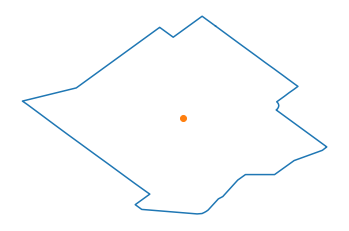

In [10]:
PD = PointsDistributor(polygon_coordinates)
PD.view_polygon()

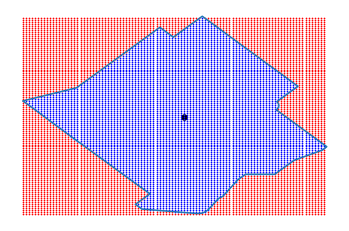

In [11]:
PD.view_grid()

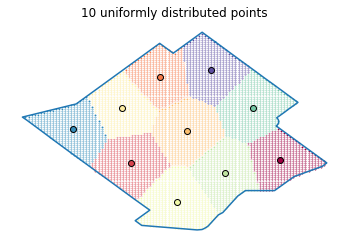

In [12]:
PD.place_points(10)
PD.view_point_placement()

In [13]:
PD.get_cluster_centers()

array([[ 2.17629449, 41.39163003],
       [ 2.16385474, 41.39135744],
       [ 2.16626309, 41.39882316],
       [ 2.16853776, 41.39412802],
       [ 2.16309616, 41.39611026],
       [ 2.16769222, 41.3879536 ],
       [ 2.17170568, 41.39051601],
       [ 2.17402537, 41.39611759],
       [ 2.15897088, 41.39427189],
       [ 2.17050998, 41.39940806]])

## Applying it to the previously described case study

In [14]:
CLIENT_ID = 'FZWQT5RYYRNBRD3KYK50VXNZ2APAF5MTKDCNEAEK1T0EWAQG' # your Foursquare ID
CLIENT_SECRET = 'UQFRDRPQM1JNCB3TSLXKZNMECFJWSBYOCU2N2KGPQFMVMKIY' # your Foursquare Secret
VERSION = '20180601'

In [24]:
PD = PointsDistributor(polygon_coordinates)
PD.place_points(15)
query_points = PD.get_cluster_centers()
print('Performing the API calls:')
all_venues = []
for point in tqdm(query_points, total = len(query_points)):
    lng,lat = point[0],point[1]
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&intent=explore&ll={},{}&limit=1000'.format(CLIENT_ID,
                                                                     CLIENT_SECRET,
                                                                     VERSION,
                                                                     lat,
                                                                     lng
                                                                     )
    #Request query
    results = requests.get(url).json()
    all_venues += [(venue['location']['lng'],venue['location']['lat']) for venue in results['response']['venues']]
#Removing duplicates
all_venues = list(set(all_venues))
#Removing venues outside the polygon
print('Checking which venues are inside the polygon:')
venue_list = []
for venue in tqdm(all_venues, total = len(all_venues)):
    if polygon.contains(Point(venue[0],venue[1])):
        venue_list.append(venue)

Performing the API calls:



Checking which venues are inside the polygon:


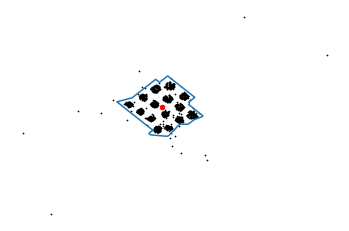

In [25]:
fig, ax = plt.subplots()
ax.plot(x_pol,y_pol)
ax.scatter(x_cen,y_cen, marker='o', s = 20, color='r')
#Plotting the venues
for venue in all_venues:
    ax.scatter(venue[0],venue[1], marker='.', s = 2, color = 'k')
plt.axis('off')
plt.show()

We can observe that the API totally fails at retrieving venues within the radius. Therefore let's plot only the ones inside the polygon:

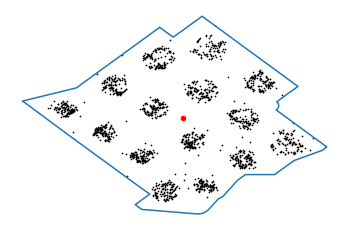

In [26]:
fig, ax = plt.subplots()
ax.plot(x_pol,y_pol)
ax.scatter(x_cen,y_cen, marker='o', s = 20, color='r')
#Plotting the venues
for venue in venue_list:
    ax.scatter(venue[0],venue[1], marker='.', s = 2, color = 'k')
plt.axis('off')
plt.show()

We still need more query points within the polygon:

Performing the API calls:



Checking which venues are inside the polygon:



Plotting the venues:


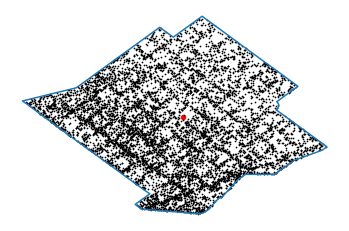

In [28]:
PD = PointsDistributor(polygon_coordinates)
PD.place_points(200)
query_points = PD.get_cluster_centers()
print('Performing the API calls:')
all_venues = []
for point in tqdm(query_points, total = len(query_points)):
    lng,lat = point[0],point[1]
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&intent=explore&ll={},{}&limit=1000'.format(CLIENT_ID,
                                                                     CLIENT_SECRET,
                                                                     VERSION,
                                                                     lat,
                                                                     lng
                                                                     )
    #Request query
    results = requests.get(url).json()
    all_venues += [(venue['location']['lng'],venue['location']['lat']) for venue in results['response']['venues']]
#Removing duplicates
all_venues = list(set(all_venues))
#Removing venues outside the polygon
print('Checking which venues are inside the polygon:')
venue_list = []
for venue in tqdm(all_venues, total = len(all_venues)):
    if polygon.contains(Point(venue[0],venue[1])):
        venue_list.append(venue)
fig, ax = plt.subplots()
ax.plot(x_pol,y_pol)
ax.scatter(x_cen,y_cen, marker='o', s = 20, color='r')
#Plotting the venues
print('Plotting the venues:')
for venue in tqdm(venue_list, total= len(venue_list)):
    ax.scatter(venue[0],venue[1], marker='.', s = 2, color = 'k')
plt.axis('off')
plt.show()

We can check how many venues are fetched depending on the number of different API calls:

In [35]:
def calculate_venue_num(call_num):
    PD = PointsDistributor(polygon_coordinates)
    PD.place_points(call_num)
    query_points = PD.get_cluster_centers()
    all_venues = []
    for point in query_points:
        lng,lat = point[0],point[1]
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&intent=explore&ll={},{}&limit=1000'.format(CLIENT_ID,
                                                                         CLIENT_SECRET,
                                                                         VERSION,
                                                                         lat,
                                                                         lng
                                                                         )
        #Request query
        results = requests.get(url).json()
        all_venues += [(venue['location']['lng'],venue['location']['lat']) for venue in results['response']['venues']]
    #Removing duplicates
    all_venues = list(set(all_venues))
    #Removing venues outside the polygon
    venue_list = []
    for venue in all_venues:
        if polygon.contains(Point(venue[0],venue[1])):
            venue_list.append(venue)
            
    return len(venue_list)

calls = np.arange(10,300,10)
venue_num = []
for call_num in tqdm(calls, total = len(calls)):
    venue_num.append(calculate_venue_num(call_num)) 

[1216,
 2374,
 3531,
 4686,
 5679,
 6508,
 7101,
 7545,
 7891,
 8147,
 8402,
 8521,
 8579,
 8589,
 8634,
 8636,
 8679,
 8665,
 8686,
 8684,
 8696,
 8701,
 8695,
 8699,
 8698,
 8700,
 8700,
 8697,
 8699]

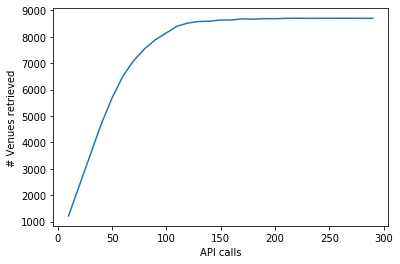

In [37]:
import seaborn as sns
sns.lineplot(x= calls, y= venue_num)
plt.xlabel('API calls')
plt.ylabel('# Venues retrieved')
plt.show()